<a href="https://colab.research.google.com/github/long2256/PoisonGAN/blob/main/sim_v0_8_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

To start working with Flower, very little is required once you have activated your Python environment (e.g. via `conda`, `virtualenv`, `pyenv`, etc). If you are running this code on Colab, there is really nothing to do except to install Flower and other dependencies. The steps below have been verified to run in Colab.

## Installing Flower

You can install flower very conveniently from `pip`:

In [1]:
# depending on your shell, you might need to add `\` before `[` and `]`.
!pip install -q flwr[simulation]
!pip install flwr_datasets[vision]
!pip install --upgrade tensorflow


We will be using the _simulation_ mode in Flower, which allows you to run a large number of clients without the overheads of manually managing devices. This is achieved via the [Virtual Client Engine](https://flower.dev/docs/framework/how-to-run-simulations.html) in Flower. With simulation, you can dynamically scale your experiments whether you run the code on your laptop, a machine with a single GPU, a server with multiple GPUs os even on a cluster with multiple servers. The `Virtual Client Engine` handles everything transparently and it allows you to specify how many resources (e.g. CPU cores, GPU VRAM) should be assigned to each virtual client.


Flower is agnostic to your choice of ML Framework. Flower works with `PyTorch`, `Tensorflow`, `NumPy`, `🤗 Transformers`, `MXNet`, `JAX`, `scikit-learn`, `fastai`, `Pandas`. Flower also supports all major platforms: `iOS`, `Android` and plain `C++`. You can find a _quickstart-_ example for each of the above in the [Flower Repository](https://github.com/adap/flower/tree/main/examples) inside the `examples/` directory.

In this tutorial we are going to use PyTorch, it comes pre-installed in your Collab runtime so there is no need to installed it again. If you wouuld like to install another version, you can still do that in the same way other packages are installed via `!pip`

We are going to install some other dependencies you are likely familiar with. Let's install `maplotlib` to plot our results at the end.

In [2]:
!pip install matplotlib

## One Client, One Data Partition

To start designing a Federated Learning pipeline we need to meet one of the key properties in FL: each client has its own data partition. To accomplish this with the MNIST dataset, we are going to generate N random partitions, where N is the total number of clients in our FL system.

We can use [Flower Datasets](https://flower.dev/docs/datasets/) to effortlessly obtain an off-the-shelf partitioned dataset or partition one that isn't pre-partitioned. Let's choose MNIST.

In [3]:
from datasets import Dataset
from flwr_datasets import FederatedDataset
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import TensorDataset

# Let's set a simulation involving a total of 100 clients
NUM_CLIENTS = 30

# Download MNIST dataset and partition the "train" partition (so one can be assigned to each client)
mnist_fds = FederatedDataset(dataset="mnist", partitioners={"train": NUM_CLIENTS})
# Let's keep the test set as is, and use it to evaluate the global model on the server
centralized_testset = mnist_fds.load_full("test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Let's create a function that returns a set of transforms to apply to our images

In [4]:
from torchvision.transforms import ToTensor, Normalize, Compose, Resize


def apply_transforms(batch):
    """Get transformation for MNIST dataset"""

    # transformation to convert images to tensors and apply normalization
    transforms = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Resize((64, 64), antialias=False)
        ])
    batch["image"] = [transforms(img) for img in batch["image"]]
    return batch

# Preparing the experiment

This tutorial is not so much about novel architectural designs so we keep things simple and make use of a typical CNN that is adequate for the MNIST image classification task.



In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

class Net(nn.Module):
    def __init__(self, num_classes: int):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.leaky1 = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.leaky2 = nn.LeakyReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.leaky3 = nn.LeakyReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.leaky4 = nn.LeakyReLU()

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.leaky5 = nn.LeakyReLU()

        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.leaky6 = nn.LeakyReLU()

        self.avgpool = nn.AvgPool2d(2, stride=2)

        self.fc = nn.Linear(4 * 4 * 128, num_classes)  # 10 classes for MNIST
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky1(x)

        x = self.conv2(x)
        x = self.leaky2(x)

        x = self.conv3(x)
        x = self.leaky3(x)

        x = self.conv4(x)
        x = self.leaky4(x)

        x = self.conv5(x)
        x = self.leaky5(x)

        x = self.conv6(x)
        x = self.leaky6(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        x = self.softmax(x)

        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.leaky1 = nn.LeakyReLU()
        self.dropout = nn.Dropout()

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.leaky2 = nn.LeakyReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.leaky3 = nn.LeakyReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.leaky4 = nn.LeakyReLU()

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.leaky5 = nn.LeakyReLU()

        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.leaky6 = nn.LeakyReLU()

        self.avgpool = nn.AvgPool2d(2, stride=2)

        self.fc = nn.Linear(4 * 4 * 128, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky1(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.batchnorm1(x)
        x = self.leaky2(x)

        x = self.conv3(x)
        x = self.batchnorm2(x)
        x = self.leaky3(x)

        x = self.conv4(x)
        x = self.batchnorm3(x)
        x = self.leaky4(x)

        x = self.conv5(x)
        x = self.batchnorm4(x)
        x = self.leaky5(x)

        x = self.conv6(x)
        x = self.leaky6(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        x = self.softmax(x)

        return x

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.conv1 = nn.ConvTranspose2d(100, 256, kernel_size=4, stride=4, padding=0, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(256)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=4, padding=0, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.tanh(x)
        return x

We'll be training the model in a Federated setting. In order to do that, we need to define two functions:

* `train()` that will train the model given a dataloader.
* `test()` that will be used to evaluate the performance of the model on held-out data, e.g., a training set.

In [6]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
def train(net, trainloader, optim, scheduler, criterion, epochs, device: str):
    """Train the network on the training set."""
    net.train()
    for _ in range(epochs):
        for batch in trainloader:
            images, labels = batch["image"].to(device), batch["label"].to(device)
            optim.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optim.step()
        scheduler.step()

def test(net, testloader, device: str):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data["image"].to(device), data["label"].to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy

# def test(net, testloader, device: str):
#     """Validate the network on the entire test set."""
#     criterion = torch.nn.CrossEntropyLoss()
#     correct_poisoned = 0
#     total_poisoned = 0
#     loss = 0.0
#     net.eval()
#     with torch.no_grad():
#         for data in testloader:
#             images, labels = data["image"].to(device), data["label"].to(device)
#             output = net(images)
#             pred = output.argmax(dim=1, keepdim=True)
#             for i in range(len(labels)):
#                 if labels[i] == 2 and pred[i].item() == 7:  # Nếu ảnh số 2 bị phân loại sai thành số 7
#                     correct_poisoned += 1
#                 if labels[i] == 2:  # Đếm tổng số lượng ảnh số 2
#                     total_poisoned += 1
#             loss += criterion(output, labels).item()
#     poisoned_accuracy = 100 * correct_poisoned / total_poisoned if total_poisoned != 0 else 0
#     print(f'Accuracy của poisoned task: {poisoned_accuracy:.2f}%')
#     return loss, poisoned_accuracy

The code we have written so far is not specific to Federated Learning. Then, what are the key differences between Federated Learning and Centralised Training? If you could only pick you, probably you'd say:
* Federated Learning is distributed -- the model is trained on-device by the participating clients.
* Data remains private and is owned by a specific _client_ -- the data is never sent to the central server.

The are several more differences. But the above two are the main ones to always consider and that are common to all flavours of Federated Learning (e.g. _cross-device_ or _cross-silo_). The remaining of this tutorial is going to focus in transforming the code we have written so far for the centralised setting and construct a Federated Learning pipeline using Flower and PyTorch.

Let's begin! 🚀

Let's next define how our FL clients will behave.

## Defining a Flower Client

You can think of a client in FL as an entity that owns some data and trains a model using this data. The caveat is that the model is being trained _collaboratively_ in Federation by multiple clients (sometimes up to hundreds of thousands) and, in most instances of FL, is sent by a central server.

A Flower Client is a simple Python class with four distinct methods:

* `fit()`: With this method, the client does on-device training for a number of epochs using its own data. At the end, the resulting model is sent back to the server for aggregation.

* `evaluate()`: With this method, the server can evaluate the performance of the global model on the local validation set of a client. This can be used for instance when there is no centralised dataset on the server for validation/test. Also, this method can be use to asses the degree of personalisation of the model being federated.

* `set_parameters()`: This method takes the parameters sent by the server and uses them to initialise the parameters of the local model that is ML framework specific (e.g. TF, Pytorch, etc).

* `get_parameters()`: It extract the parameters from the local model and transforms them into a list of NumPy arrays. This ML framework-agnostic representation of the model will be sent to the server.

Let's start by importing Flower!

In [7]:
import flwr as fl

Now let's defice our Flower Client class:

In [8]:
from collections import OrderedDict
from typing import Dict, List, Tuple, Union, Optional
from flwr.server.client_proxy import ClientProxy
from flwr.common import NDArrays, Scalar, Parameters


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, trainloader, valloader, testloader) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = valloader
        self.testloader = testloader
        self.cid = cid
        self.model = Net(num_classes=10)
        self.discriminator = Discriminator()
        self.generator = Generator()
        # Determine device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)  # send model to device
        self.discriminator.to(self.device)
        self.generator.to(self.device)

    def set_parameters(self, parameters):
        """With the model paramters received from the server,
        overwrite the uninitialise model in this class with them."""

        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # now replace the parameters
        self.discriminator.load_state_dict(state_dict, strict=False)
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract all model parameters and conver them to a list of
        NumPy arryas. The server doesn't work with PyTorch/TF/etc."""
        # print(f"[Client {self.cid}] get_parameters")
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""
        # print(f"[Client {self.cid}] fit, config: {config}")
        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)
        lr, epochs = config["lr"], config["epochs"]
        optim = torch.optim.SGD(self.model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optim, step_size=2, gamma=0.1)
        criterion = torch.nn.CrossEntropyLoss()
        # if self.cid == 0:
        #     attacker_lr, attacker_epochs = config["attacker_lr"], config["attacker_epochs"]
        #     loss, accuracy = test(self.model, self.testloader, device=self.device)
        #     optim_G = torch.optim.SGD(self.generator.parameters(), lr=lr)
        #     if accuracy > 60:
        #         train(net=self.model, trainloader=self.trainloader, optim=optim, scheduler=scheduler, criterion=criterion, epochs=epochs, device=self.device)
        #         poison_train(net=self.model, generator=self.generator, discriminator=self.discriminator, optim_G=optim_G, optim_net=optim, scheduler=scheduler, criterion=criterion, epochs=epochs, device=self.device)
        #     else:
        #         poison_train(net=self.model, generator=self.generator, discriminator=self.discriminator, optim_G=optim_G, optim_net=optim, scheduler=scheduler, criterion=criterion, epochs=epochs, device=self.device)
        # else:
        #     train(net=self.model, trainloader=self.trainloader, optim=optim, scheduler=scheduler, criterion=criterion, epochs=epochs, device=self.device)

        train(net=self.model, trainloader=self.trainloader, optim=optim, scheduler=scheduler, criterion=criterion, epochs=epochs, device=self.device)
        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        self.set_parameters(parameters)
        loss, accuracy = test(self.model, self.valloader, device=self.device)
        # print(f"[Client {self.cid}] evaluate, config: {config}, local accuracy: {accuracy}")
        # send statistics back to the server
        return float(loss), len(self.valloader), {"accuracy": accuracy}

Spend a few minutes to inspect the `FlowerClient` class above. Please ask questions if there is something unclear !

Then keen-eyed among you might have realised that if we were to fuse the client's `fit()` and `evaluate()` methods, we'll end up with essentially the same as in the `run_centralised()` function we used in the Centralised Training part of this tutorial. And it is true!! In Federated Learning, the way clients perform local training makes use of the same principles as more traditional centralised setup. The key difference is that the dataset now is much smaller and it's never _"seen"_ by the entity running the FL workload (i.e. the central server).


Talking about the central server... we should define what strategy we want to make use of so the updated models sent from the clients back to the server at the end of the `fit()` method are aggregate.


## Choosing a Flower Strategy


A strategy sits at the core of the Federated Learning experiment. It is involved in all stages of a FL pipeline: sampling clients; sending the _global model_ to the clients so they can do `fit()`; receive the updated models from the clients and **aggregate** these to construct a new _global model_; define and execute global or federated evaluation; and more.

Flower comes with [many strategies built-in](https://github.com/adap/flower/tree/main/src/py/flwr/server/strategy) and more to be available in the next release (`1.5` already!). For this tutorial, let's use what is arguable the most popular strategy out there: `FedAvg`.

The way `FedAvg` works is simple but performs surprisingly well in practice. It is therefore one good strategy to start your experimentation. `FedAvg`, as its name implies, derives a new version of the _global model_ by taking the average of all the models sent by clients participating in the round. You can read all the details [in the paper](https://arxiv.org/abs/1602.05629).

Let's see how we can define `FedAvg` using Flower. We use one of the callbacks called `evaluate_fn` so we can easily evaluate the state of the global model using a small centralised testset. Note this functionality is user-defined since it requires a choice in terms of ML-framework. (if you recall, Flower is framework agnostic).

> This being said, centralised evaluation of the global model is only possible if there exists a centralised dataset that somewhat follows a similar distribution as the data that's spread across clients. In some cases having such centralised dataset for validation is not possible, so the only solution is to federate the evaluation of the _global model_. This is the default behaviour in Flower. If you don't specify teh `evaluate_fn` argument in your strategy, then, centralised global evaluation won't be performed.

In [9]:
import glob
import os
def load_model_state_dict():
    net = Net(10)
    list_of_files = [fname for fname in glob.glob("./model_round_*")]
    latest_round_file = max(list_of_files, key=os.path.getctime)
    # latest_round_file = './model_round_df.pth'
    print("Loading pre-trained model from: ", latest_round_file)
    state_dict = torch.load(latest_round_file)
    net.load_state_dict(state_dict)
    return net

In [10]:
def get_evaluate_fn(centralized_testset: Dataset):
    """This is a function that returns a function. The returned
    function (i.e. `evaluate_fn`) will be executed by the strategy
    at the end of each round to evaluate the stat of the global
    model."""

    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate
        a model and replace its parameters with those from the global model.
        The, the model will be evaluate on the test set (recall this is the
        whole MNIST test set)."""

        # model = Net(num_classes=10)

        # # Determine device
        # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        # model.to(device)  # send model to device

        # # set parameters to the model
        # params_dict = zip(model.state_dict().keys(), parameters)
        # state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # model.load_state_dict(state_dict, strict=True)

        ###############################################################################
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = load_model_state_dict()
        model.to(device)

        # Apply transform to dataset
        testset = centralized_testset.with_transform(apply_transforms)

        testloader = DataLoader(testset, batch_size=50)
        # call test
        loss, accuracy = test(model, testloader, device)
        print('GLOBAL TEST')
        return loss, {"accuracy": accuracy}

    return evaluate_fn

We could now define a strategy just as shown (commented) above. Instead, let's see how additional (but entirely optional) functionality can be easily added to our strategy. We are going to define two additional auxiliary functions to: (1) be able to configure how clients do local training; and (2) define a function to aggregate the metrics that clients return after running their `evaluate` methods:

1. `fit_config()`. This is a function that will be executed inside the strategy when configuring a new `fit` round. This function is relatively simple and only requires as input argument the round at which the FL experiment is at. In this example we simply return a Python dictionary to specify the number of epochs and learning rate each client should made use of inside their `fit()` methods. A more versatile implementation would add more hyperparameters (e.g. the learning rate) and adjust them as the FL process advances (e.g. reducing the learning rate in later FL rounds).
2. `weighted_average()`: This is an optional function to pass to the strategy. It will be executed after an evaluation round (i.e. when client run `evaluate()`) and will aggregate the metrics clients return. In this example, we use this function to compute the weighted average accuracy of clients doing `evaluate()`.

In [67]:
from flwr.common import Metrics, FitRes


def fit_config(server_round: int) -> Dict[str, Scalar]:
    """Return a configuration with static batch size and (local) epochs."""
    config = {
        "epochs": 10,  # Number of local epochs done by clients
        "lr": 0.1,  # Learning rate to use by clients during fit()
        "attacker_epochs": 20,
        "attacker_lr": 0.05,
    }
    return config


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

Now we can define our strategy:

In [68]:
import numpy as np
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate model weights using weighted average and store checkpoint"""
        model=Net(10)
        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            print(f"Saving round {server_round} aggregated_parameters...")

            # Convert `Parameters` to `List[np.ndarray]`
            aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

            # Convert `List[np.ndarray]` to PyTorch`state_dict`
            params_dict = zip(model.state_dict().keys(), aggregated_ndarrays)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            model.load_state_dict(state_dict, strict=True)

            # Save the model
            torch.save(model.state_dict(), f"model_round_{server_round}.pth")
        return aggregated_parameters, aggregated_metrics

In [69]:
strategy = SaveModelStrategy(
    fraction_fit=0.34,  # Sample 10% of available clients for training
    fraction_evaluate=0.34,  # Sample 5% of available clients for evaluation
    on_fit_config_fn=fit_config,
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(centralized_testset),  # global evaluation function
)

So far we have:
* created the dataset partitions (one for each client)
* defined the client class
* decided on a strategy to use

Now we just need to launch the Flower FL experiment... not so fast! just one final function: let's create another callback that the Simulation Engine will use in order to span VirtualClients. As you can see this is really simple: construct a FlowerClient object, assigning each their own data partition.

In [70]:
from torch.utils.data import DataLoader


def get_client_fn(dataset: FederatedDataset):
    """Return a function to construct a client.

    The VirtualClientEngine will execute this function whenever a client is sampled by
    the strategy to participate.
    """

    def client_fn(cid: str) -> fl.client.Client:
        """Construct a FlowerClient with its own dataset partition."""

        # Let's get the partition corresponding to the i-th client
        client_dataset = dataset.load_partition(int(cid), "train")

        # Now let's split it into train (90%) and validation (10%)
        client_dataset_splits = client_dataset.train_test_split(test_size=0.1)

        trainset = client_dataset_splits["train"]
        valset = client_dataset_splits["test"]

        # Now we apply the transform to each batch.
        trainloader = DataLoader(
            trainset.with_transform(apply_transforms), batch_size=32, shuffle=True
        )
        valloader = DataLoader(valset.with_transform(apply_transforms), batch_size=32)
        testset = centralized_testset.with_transform(apply_transforms)

        testloader = DataLoader(testset, batch_size=50)
        # Create and return client
        return FlowerClient(int(cid), trainloader, valloader, testloader)

    return client_fn


client_fn_callback = get_client_fn(mnist_fds)

Now we are ready to launch the FL experiment using Flower simulation:

In [71]:
# # With a dictionary, you tell Flower's VirtualClientEngine that each
# # client needs exclusive access to these many resources in order to run
# client_resources = {"num_cpus": 0.2, "num_gpus": 0.1}

# # Let's disable tqdm progress bar in the main thread (used by the server)
# disable_progress_bar()

# history = fl.simulation.start_simulation(
#     client_fn=client_fn_callback,  # a callback to construct a client
#     num_clients=NUM_CLIENTS,  # total number of clients in the experiment
#     config=fl.server.ServerConfig(num_rounds=10),  # let's run for 10 rounds
#     strategy=strategy,  # the strategy that will orchestrate the whole FL pipeline
#     client_resources=client_resources,
#     actor_kwargs={
#         "on_actor_init_fn": disable_progress_bar  # disable tqdm on each actor/process spawning virtual clients
#     },
# )

Doing 10 rounds should take less than 2 minutes on a CPU-only Colab instance <-- Flower Simulation is fast! 🚀

You can then use the resturned `History` object to either save the results to disk or do some visualisation (or both of course, or neither if you like chaos). Below you can see how you can plot the centralised accuracy obtainined at the end of each round (including at the very beginning of the experiment) for the _global model_. This is want the function `evaluate_fn()` that we passed to the strategy reports.

In [72]:
# import matplotlib.pyplot as plt

# print(f"{history.metrics_centralized = }")

# global_accuracy_centralised = history.metrics_centralized["accuracy"]
# round = [data[0] for data in global_accuracy_centralised]
# acc = [data[1] for data in global_accuracy_centralised]
# plt.plot(round, acc)
# plt.grid()
# plt.ylabel("Accuracy (%)")
# plt.xlabel("Round")
# plt.title("MNIST - IID - 30 clients with 10 clients per round")

Congratulations! With that, you built a Flower client, customized it's instantiation through the `client_fn`, customized the server-side execution through a `FedAvg` strategy configured for this workload, and started a simulation with 100 clients (each holding their own individual partition of the MNIST dataset).

Next, you can continue to explore more advanced Flower topics:

- Deploy server and clients on different machines using `start_server` and `start_client`
- Customize the server-side execution through custom strategies
- Customize the client-side execution through `config` dictionaries

Get all resources you need!

* **[DOCS]** Our complete documenation: https://flower.dev/docs/
* **[Examples]** All Flower examples: https://flower.dev/docs/examples/
* **[VIDEO]** Our Youtube channel: https://www.youtube.com/@flowerlabs

Don't forget to join our Slack channel: https://flower.dev/join-slack/


In [73]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def test(net, testloader, device: str):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct_poisoned = 0
    total_poisoned = 0
    loss = 0.0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data["image"].to(device), data["label"].to(device)
            output = net(images)
            pred = output.argmax(dim=1, keepdim=True)
            for i in range(len(labels)):
                if labels[i] == 2 and pred[i].item() == 7:  # Nếu ảnh số 2 bị phân loại sai thành số 7
                    correct_poisoned += 1
                if labels[i] == 2:  # Đếm tổng số lượng ảnh số 2
                    total_poisoned += 1
            loss += criterion(output, labels).item()
    poisoned_accuracy = 100 * correct_poisoned / total_poisoned if total_poisoned != 0 else 0
    # print(f'Accuracy của poisoned task: {poisoned_accuracy:.2f}%')
    return loss, poisoned_accuracy

In [74]:
from tqdm.notebook import tqdm
def poison_train(net, generator, discriminator, optim_G, optim_net, G_scheduler, scheduler, criterion, epochs, device: str):

    discriminator.eval()
    generator.train()
    for epoch in range(epochs):
        i,j=0,0
        # Training G
        noise = torch.randn(18, 256, 100, 1, 1).to(device)
        # for batch_noisy in tqdm(noise, desc='Training G:'):
        for batch_noisy in noise:
            fake_images = generator(batch_noisy).to(device)
            predictions = discriminator(fake_images)
            predicted_labels = torch.max(predictions, dim=1).indices

            images_not_2 = fake_images[predicted_labels != 2]
            labels_is_2 = torch.full((len(images_not_2),), 2).to(device)

            if(len(images_not_2) > 0):
                optim_G.zero_grad()
                criterion(discriminator(images_not_2.to(device)), labels_is_2.to(device)).backward()
                optim_G.step()
                i = i+1


        # Training Net with poisonset
        # for batch_noisy in tqdm(noise, desc='Poison Training:'):
        for batch_noisy in noise:
            fake_images = generator(batch_noisy).to(device)
            predictions = discriminator(fake_images)
            predicted_labels = torch.max(predictions, dim=1).indices

            images_is_2 = fake_images[predicted_labels == 2]
            labels_is_7 = torch.full((len(images_is_2),), 7).to(device)

            if(len(images_is_2) > 0):
                optim_net.zero_grad()
                criterion(net(images_is_2.to(device)), labels_is_7.to(device)).backward()
                for param in net.parameters():
                    if param.grad is not None:
                        param.grad *= 20
                optim_net.step()
                j=j+1
        if(i > 0):
            G_scheduler.step()
        if(j > 0):
            scheduler.step()


In [75]:
class FlowerClient(FlowerClient):
    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""
        # print(f"[Client {self.cid}] fit, config: {config}")
        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)
        lr, epochs = config["lr"], config["epochs"]
        optim = torch.optim.SGD(self.model.parameters(), lr=lr)
        scheduler = lr_scheduler.StepLR(optim, step_size=2, gamma=0.1)
        criterion = torch.nn.CrossEntropyLoss()
        criterion_G = torch.nn.CrossEntropyLoss()
        if self.cid == 0:
            print('ATTACKER')
            attacker_lr, attacker_epochs = config["attacker_lr"], config["attacker_epochs"]
            loss, accuracy = test(self.model, self.testloader, device=self.device)
            optim_G = torch.optim.SGD(self.generator.parameters(), lr=attacker_lr)
            optim_net = torch.optim.SGD(self.model.parameters(), lr=attacker_lr)
            G_scheduler = lr_scheduler.StepLR(optim_G, step_size=2, gamma=0.1)
            if accuracy > 60:
                train(net=self.model, trainloader=self.trainloader, optim=optim, scheduler=scheduler, criterion=criterion, epochs=epochs, device=self.device)
                poison_train(self.model, self.generator, self.discriminator, optim_G, optim_net, G_scheduler, scheduler, criterion, attacker_epochs, self.device)
            else:
                poison_train(self.model, self.generator, self.discriminator, optim_G, optim_net, G_scheduler, scheduler, criterion, attacker_epochs, self.device)
        else:
            train(net=self.model, trainloader=self.trainloader, optim=optim, scheduler=scheduler, criterion=criterion, epochs=epochs, device=self.device)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

In [76]:
import glob
import os
net = Net(10)
# list_of_files = [fname for fname in glob.glob("./model_round_*")]
# latest_round_file = max(list_of_files, key=os.path.getctime)
latest_round_file = './model_round_df.pth'
print("Loading pre-trained model from: ", latest_round_file)
state_dict = torch.load(latest_round_file)
net.load_state_dict(state_dict)

Loading pre-trained model from:  ./model_round_df.pth


<All keys matched successfully>

In [77]:
def get_parameters():
    """Extract all model parameters and conver them to a list of
    NumPy arryas. The server doesn't work with PyTorch/TF/etc."""
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [78]:
params = get_parameters()

strategy = SaveModelStrategy(
    fraction_fit=0.34,  # Sample 10% of available clients for training
    fraction_evaluate=1,  # Sample 5% of available clients for evaluation
    on_fit_config_fn=fit_config,
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(centralized_testset),  # global evaluation function
    initial_parameters=fl.common.ndarrays_to_parameters(params),
)

In [79]:
# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 2, "num_gpus": 1}

# Let's disable tqdm progress bar in the main thread (used by the server)
disable_progress_bar()
history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,  # a callback to construct a client
    num_clients=NUM_CLIENTS,  # total number of clients in the experiment
    config=fl.server.ServerConfig(num_rounds=20),  # let's run for 10 rounds
    strategy=strategy,  # the strategy that will orchestrate the whole FL pipeline
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": disable_progress_bar  # disable tqdm on each actor/process spawning virtual clients
    },
)

INFO flwr 2024-01-11 10:28:03,398 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=20, round_timeout=None)
2024-01-11 10:28:07,847	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-01-11 10:28:10,210 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 7701403239.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3850701619.0, 'CPU': 2.0, 'node:__internal_head__': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7701403239.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3850701619.0, 'CPU': 2.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-01-11 10:28:10,227 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.htm

Loading pre-trained model from:  ./model_round_20.pth


(pid=73008) 2024-01-11 10:28:12.974643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=73008) 2024-01-11 10:28:12.974708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=73008) 2024-01-11 10:28:12.976505: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=73008) 2024-01-11 10:28:18.497645: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO flwr 2024-01-11 10:28:18,771 | server.py:94 | initial parameters (loss, other metrics): 471.6701533794403, {'accuracy': 100.0}
INFO:flwr:initial parameters (loss, other metrics): 471.67015

GLOBAL TEST
(DefaultActor pid=73008) ATTACKER


(DefaultActor pid=73008) /usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
(DefaultActor pid=73008)   warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
DEBUG flwr 2024-01-11 10:30:47,668 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
WARNING flwr 2024-01-11 10:30:47,741 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


Saving round 1 aggregated_parameters...
Loading pre-trained model from:  ./model_round_1.pth


INFO flwr 2024-01-11 10:30:54,283 | server.py:125 | fit progress: (1, 372.224481344223, {'accuracy': 29.651162790697676}, 155.5015406010025)
INFO:flwr:fit progress: (1, 372.224481344223, {'accuracy': 29.651162790697676}, 155.5015406010025)
DEBUG flwr 2024-01-11 10:30:54,287 | server.py:173 | evaluate_round 1: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 1: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 10:31:00,483 | server.py:187 | evaluate_round 1 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 30 results and 0 failures
DEBUG flwr 2024-01-11 10:31:00,486 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 30)


(DefaultActor pid=73008) ATTACKER


DEBUG flwr 2024-01-11 10:33:28,251 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures


Saving round 2 aggregated_parameters...
Loading pre-trained model from:  ./model_round_2.pth


INFO flwr 2024-01-11 10:33:33,774 | server.py:125 | fit progress: (2, 392.936919093132, {'accuracy': 82.94573643410853}, 314.9921066019997)
INFO:flwr:fit progress: (2, 392.936919093132, {'accuracy': 82.94573643410853}, 314.9921066019997)
DEBUG flwr 2024-01-11 10:33:33,778 | server.py:173 | evaluate_round 2: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 2: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 10:33:40,702 | server.py:187 | evaluate_round 2 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 30 results and 0 failures
DEBUG flwr 2024-01-11 10:33:40,705 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 30)
DEBUG flwr 2024-01-11 10:35:28,067 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures


Saving round 3 aggregated_parameters...
Loading pre-trained model from:  ./model_round_3.pth


INFO flwr 2024-01-11 10:35:34,096 | server.py:125 | fit progress: (3, 318.4245939254761, {'accuracy': 1.065891472868217}, 435.314490003002)
INFO:flwr:fit progress: (3, 318.4245939254761, {'accuracy': 1.065891472868217}, 435.314490003002)
DEBUG flwr 2024-01-11 10:35:34,104 | server.py:173 | evaluate_round 3: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 3: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 10:35:40,861 | server.py:187 | evaluate_round 3 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 30 results and 0 failures
DEBUG flwr 2024-01-11 10:35:40,864 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 30)


(DefaultActor pid=73008) ATTACKER


DEBUG flwr 2024-01-11 10:38:07,178 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures


Saving round 4 aggregated_parameters...
Loading pre-trained model from:  ./model_round_4.pth


INFO flwr 2024-01-11 10:38:14,316 | server.py:125 | fit progress: (4, 318.24841034412384, {'accuracy': 1.2596899224806202}, 595.534234652001)
INFO:flwr:fit progress: (4, 318.24841034412384, {'accuracy': 1.2596899224806202}, 595.534234652001)
DEBUG flwr 2024-01-11 10:38:14,320 | server.py:173 | evaluate_round 4: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 4: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 10:38:20,532 | server.py:187 | evaluate_round 4 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 30 results and 0 failures
DEBUG flwr 2024-01-11 10:38:20,535 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 30)
DEBUG flwr 2024-01-11 10:40:08,871 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures


Saving round 5 aggregated_parameters...
Loading pre-trained model from:  ./model_round_5.pth


INFO flwr 2024-01-11 10:40:14,228 | server.py:125 | fit progress: (5, 316.961106300354, {'accuracy': 0.872093023255814}, 715.4460252810022)
INFO:flwr:fit progress: (5, 316.961106300354, {'accuracy': 0.872093023255814}, 715.4460252810022)
DEBUG flwr 2024-01-11 10:40:14,233 | server.py:173 | evaluate_round 5: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 5: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 10:40:21,856 | server.py:187 | evaluate_round 5 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 30 results and 0 failures
DEBUG flwr 2024-01-11 10:40:21,859 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 6: strategy sampled 10 clients (out of 30)


(DefaultActor pid=73008) ATTACKER


DEBUG flwr 2024-01-11 10:42:48,127 | server.py:236 | fit_round 6 received 10 results and 0 failures
DEBUG:flwr:fit_round 6 received 10 results and 0 failures


Saving round 6 aggregated_parameters...
Loading pre-trained model from:  ./model_round_6.pth


INFO flwr 2024-01-11 10:42:54,797 | server.py:125 | fit progress: (6, 356.9332708120346, {'accuracy': 37.1124031007752}, 876.0153615740019)
INFO:flwr:fit progress: (6, 356.9332708120346, {'accuracy': 37.1124031007752}, 876.0153615740019)
DEBUG flwr 2024-01-11 10:42:54,801 | server.py:173 | evaluate_round 6: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 6: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 10:43:01,043 | server.py:187 | evaluate_round 6 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 30 results and 0 failures
DEBUG flwr 2024-01-11 10:43:01,047 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 7: strategy sampled 10 clients (out of 30)
DEBUG flwr 2024-01-11 10:44:50,048 | server.py:236 | fit_round 7 received 10 results and 0 failures
DEBUG:flwr:fit_round 7 received 10 results and 0 failures


Saving round 7 aggregated_parameters...
Loading pre-trained model from:  ./model_round_7.pth


INFO flwr 2024-01-11 10:44:55,427 | server.py:125 | fit progress: (7, 316.5138039588928, {'accuracy': 0.872093023255814}, 996.6455602040005)
INFO:flwr:fit progress: (7, 316.5138039588928, {'accuracy': 0.872093023255814}, 996.6455602040005)
DEBUG flwr 2024-01-11 10:44:55,433 | server.py:173 | evaluate_round 7: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 7: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 10:45:02,958 | server.py:187 | evaluate_round 7 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 30 results and 0 failures
DEBUG flwr 2024-01-11 10:45:02,961 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 8: strategy sampled 10 clients (out of 30)
DEBUG flwr 2024-01-11 10:46:51,062 | server.py:236 | fit_round 8 received 10 results and 0 failures
DEBUG:flwr:fit_round 8 received 10 results and 0 failures


Saving round 8 aggregated_parameters...
Loading pre-trained model from:  ./model_round_8.pth


INFO flwr 2024-01-11 10:46:57,664 | server.py:125 | fit progress: (8, 315.8574855327606, {'accuracy': 0.6782945736434108}, 1118.8827719210021)
INFO:flwr:fit progress: (8, 315.8574855327606, {'accuracy': 0.6782945736434108}, 1118.8827719210021)
DEBUG flwr 2024-01-11 10:46:57,668 | server.py:173 | evaluate_round 8: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 8: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 10:47:03,913 | server.py:187 | evaluate_round 8 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 30 results and 0 failures
DEBUG flwr 2024-01-11 10:47:03,916 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 9: strategy sampled 10 clients (out of 30)
DEBUG flwr 2024-01-11 10:48:54,327 | server.py:236 | fit_round 9 received 10 results and 0 failures
DEBUG:flwr:fit_round 9 received 10 results and 0 failures


Saving round 9 aggregated_parameters...
Loading pre-trained model from:  ./model_round_9.pth


INFO flwr 2024-01-11 10:49:00,760 | server.py:125 | fit progress: (9, 315.4378982782364, {'accuracy': 0.6782945736434108}, 1241.9787771590018)
INFO:flwr:fit progress: (9, 315.4378982782364, {'accuracy': 0.6782945736434108}, 1241.9787771590018)
DEBUG flwr 2024-01-11 10:49:00,767 | server.py:173 | evaluate_round 9: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 9: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 10:49:07,426 | server.py:187 | evaluate_round 9 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 30 results and 0 failures
DEBUG flwr 2024-01-11 10:49:07,429 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 10: strategy sampled 10 clients (out of 30)
DEBUG flwr 2024-01-11 10:50:58,158 | server.py:236 | fit_round 10 received 10 results and 0 failures
DEBUG:flwr:fit_round 10 received 10 results and 0 failures


Saving round 10 aggregated_parameters...
Loading pre-trained model from:  ./model_round_10.pth


INFO flwr 2024-01-11 10:51:03,556 | server.py:125 | fit progress: (10, 315.0220185518265, {'accuracy': 0.7751937984496124}, 1364.7744399559997)
INFO:flwr:fit progress: (10, 315.0220185518265, {'accuracy': 0.7751937984496124}, 1364.7744399559997)
DEBUG flwr 2024-01-11 10:51:03,560 | server.py:173 | evaluate_round 10: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 10: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 10:51:11,287 | server.py:187 | evaluate_round 10 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 30 results and 0 failures
DEBUG flwr 2024-01-11 10:51:11,291 | server.py:222 | fit_round 11: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 11: strategy sampled 10 clients (out of 30)
DEBUG flwr 2024-01-11 10:53:01,591 | server.py:236 | fit_round 11 received 10 results and 0 failures
DEBUG:flwr:fit_round 11 received 10 results and 0 failures


Saving round 11 aggregated_parameters...
Loading pre-trained model from:  ./model_round_11.pth


INFO flwr 2024-01-11 10:53:07,731 | server.py:125 | fit progress: (11, 314.81985688209534, {'accuracy': 0.6782945736434108}, 1488.949054511002)
INFO:flwr:fit progress: (11, 314.81985688209534, {'accuracy': 0.6782945736434108}, 1488.949054511002)
DEBUG flwr 2024-01-11 10:53:07,739 | server.py:173 | evaluate_round 11: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 11: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 10:53:13,968 | server.py:187 | evaluate_round 11 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 30 results and 0 failures
DEBUG flwr 2024-01-11 10:53:13,972 | server.py:222 | fit_round 12: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 12: strategy sampled 10 clients (out of 30)


(DefaultActor pid=73008) ATTACKER


DEBUG flwr 2024-01-11 10:55:46,278 | server.py:236 | fit_round 12 received 10 results and 0 failures
DEBUG:flwr:fit_round 12 received 10 results and 0 failures


Saving round 12 aggregated_parameters...
Loading pre-trained model from:  ./model_round_12.pth


INFO flwr 2024-01-11 10:55:52,345 | server.py:125 | fit progress: (12, 314.9880726337433, {'accuracy': 1.8410852713178294}, 1653.5633555420027)
INFO:flwr:fit progress: (12, 314.9880726337433, {'accuracy': 1.8410852713178294}, 1653.5633555420027)
DEBUG flwr 2024-01-11 10:55:52,352 | server.py:173 | evaluate_round 12: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 12: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 10:55:59,265 | server.py:187 | evaluate_round 12 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 30 results and 0 failures
DEBUG flwr 2024-01-11 10:55:59,270 | server.py:222 | fit_round 13: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 13: strategy sampled 10 clients (out of 30)
DEBUG flwr 2024-01-11 10:57:51,537 | server.py:236 | fit_round 13 received 10 results and 0 failures
DEBUG:flwr:fit_round 13 received 10 results and 0 failures


Saving round 13 aggregated_parameters...
Loading pre-trained model from:  ./model_round_13.pth


INFO flwr 2024-01-11 10:57:56,940 | server.py:125 | fit progress: (13, 314.5111266374588, {'accuracy': 0.5813953488372093}, 1778.1582991060022)
INFO:flwr:fit progress: (13, 314.5111266374588, {'accuracy': 0.5813953488372093}, 1778.1582991060022)
DEBUG flwr 2024-01-11 10:57:56,943 | server.py:173 | evaluate_round 13: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 13: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 10:58:04,621 | server.py:187 | evaluate_round 13 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 30 results and 0 failures
DEBUG flwr 2024-01-11 10:58:04,625 | server.py:222 | fit_round 14: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 14: strategy sampled 10 clients (out of 30)


(DefaultActor pid=73008) ATTACKER


DEBUG flwr 2024-01-11 11:00:36,556 | server.py:236 | fit_round 14 received 10 results and 0 failures
DEBUG:flwr:fit_round 14 received 10 results and 0 failures


Saving round 14 aggregated_parameters...
Loading pre-trained model from:  ./model_round_14.pth


INFO flwr 2024-01-11 11:00:42,584 | server.py:125 | fit progress: (14, 317.2615453004837, {'accuracy': 3.197674418604651}, 1943.8019961970022)
INFO:flwr:fit progress: (14, 317.2615453004837, {'accuracy': 3.197674418604651}, 1943.8019961970022)
DEBUG flwr 2024-01-11 11:00:42,587 | server.py:173 | evaluate_round 14: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 14: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 11:00:49,106 | server.py:187 | evaluate_round 14 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 30 results and 0 failures
DEBUG flwr 2024-01-11 11:00:49,111 | server.py:222 | fit_round 15: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 15: strategy sampled 10 clients (out of 30)
DEBUG flwr 2024-01-11 11:02:41,986 | server.py:236 | fit_round 15 received 10 results and 0 failures
DEBUG:flwr:fit_round 15 received 10 results and 0 failures


Saving round 15 aggregated_parameters...
Loading pre-trained model from:  ./model_round_15.pth


INFO flwr 2024-01-11 11:02:48,716 | server.py:125 | fit progress: (15, 314.17546570301056, {'accuracy': 0.4844961240310077}, 2069.933877927)
INFO:flwr:fit progress: (15, 314.17546570301056, {'accuracy': 0.4844961240310077}, 2069.933877927)
DEBUG flwr 2024-01-11 11:02:48,721 | server.py:173 | evaluate_round 15: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 15: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 11:02:55,023 | server.py:187 | evaluate_round 15 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 30 results and 0 failures
DEBUG flwr 2024-01-11 11:02:55,027 | server.py:222 | fit_round 16: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 16: strategy sampled 10 clients (out of 30)
DEBUG flwr 2024-01-11 11:04:48,443 | server.py:236 | fit_round 16 received 10 results and 0 failures
DEBUG:flwr:fit_round 16 received 10 results and 0 failures


Saving round 16 aggregated_parameters...
Loading pre-trained model from:  ./model_round_16.pth


INFO flwr 2024-01-11 11:04:55,216 | server.py:125 | fit progress: (16, 313.8613234758377, {'accuracy': 0.4844961240310077}, 2196.434829905)
INFO:flwr:fit progress: (16, 313.8613234758377, {'accuracy': 0.4844961240310077}, 2196.434829905)
DEBUG flwr 2024-01-11 11:04:55,221 | server.py:173 | evaluate_round 16: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 16: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 11:05:01,460 | server.py:187 | evaluate_round 16 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 30 results and 0 failures
DEBUG flwr 2024-01-11 11:05:01,465 | server.py:222 | fit_round 17: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 17: strategy sampled 10 clients (out of 30)
DEBUG flwr 2024-01-11 11:06:54,262 | server.py:236 | fit_round 17 received 10 results and 0 failures
DEBUG:flwr:fit_round 17 received 10 results and 0 failures


Saving round 17 aggregated_parameters...
Loading pre-trained model from:  ./model_round_17.pth


INFO flwr 2024-01-11 11:07:00,075 | server.py:125 | fit progress: (17, 313.7130950689316, {'accuracy': 0.4844961240310077}, 2321.2935976530025)
INFO:flwr:fit progress: (17, 313.7130950689316, {'accuracy': 0.4844961240310077}, 2321.2935976530025)
DEBUG flwr 2024-01-11 11:07:00,080 | server.py:173 | evaluate_round 17: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 17: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 11:07:07,363 | server.py:187 | evaluate_round 17 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 30 results and 0 failures
DEBUG flwr 2024-01-11 11:07:07,366 | server.py:222 | fit_round 18: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 18: strategy sampled 10 clients (out of 30)
DEBUG flwr 2024-01-11 11:09:00,932 | server.py:236 | fit_round 18 received 10 results and 0 failures
DEBUG:flwr:fit_round 18 received 10 results and 0 failures


Saving round 18 aggregated_parameters...
Loading pre-trained model from:  ./model_round_18.pth


INFO flwr 2024-01-11 11:09:06,364 | server.py:125 | fit progress: (18, 313.51318860054016, {'accuracy': 0.1937984496124031}, 2447.5823231249997)
INFO:flwr:fit progress: (18, 313.51318860054016, {'accuracy': 0.1937984496124031}, 2447.5823231249997)
DEBUG flwr 2024-01-11 11:09:06,368 | server.py:173 | evaluate_round 18: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 18: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 11:09:13,958 | server.py:187 | evaluate_round 18 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 30 results and 0 failures
DEBUG flwr 2024-01-11 11:09:13,962 | server.py:222 | fit_round 19: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 19: strategy sampled 10 clients (out of 30)
DEBUG flwr 2024-01-11 11:11:06,322 | server.py:236 | fit_round 19 received 10 results and 0 failures
DEBUG:flwr:fit_round 19 received 10 results and 0 failures


Saving round 19 aggregated_parameters...
Loading pre-trained model from:  ./model_round_19.pth


INFO flwr 2024-01-11 11:11:11,783 | server.py:125 | fit progress: (19, 313.43115293979645, {'accuracy': 0.4844961240310077}, 2573.0017828130003)
INFO:flwr:fit progress: (19, 313.43115293979645, {'accuracy': 0.4844961240310077}, 2573.0017828130003)
DEBUG flwr 2024-01-11 11:11:11,790 | server.py:173 | evaluate_round 19: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 19: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 11:11:19,453 | server.py:187 | evaluate_round 19 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 30 results and 0 failures
DEBUG flwr 2024-01-11 11:11:19,457 | server.py:222 | fit_round 20: strategy sampled 10 clients (out of 30)
DEBUG:flwr:fit_round 20: strategy sampled 10 clients (out of 30)
DEBUG flwr 2024-01-11 11:13:11,633 | server.py:236 | fit_round 20 received 10 results and 0 failures
DEBUG:flwr:fit_round 20 received 10 results and 0 failures


Saving round 20 aggregated_parameters...
Loading pre-trained model from:  ./model_round_20.pth


INFO flwr 2024-01-11 11:13:17,396 | server.py:125 | fit progress: (20, 313.1972391605377, {'accuracy': 0.4844961240310077}, 2698.6146398460005)
INFO:flwr:fit progress: (20, 313.1972391605377, {'accuracy': 0.4844961240310077}, 2698.6146398460005)
DEBUG flwr 2024-01-11 11:13:17,400 | server.py:173 | evaluate_round 20: strategy sampled 30 clients (out of 30)
DEBUG:flwr:evaluate_round 20: strategy sampled 30 clients (out of 30)


GLOBAL TEST


DEBUG flwr 2024-01-11 11:13:23,991 | server.py:187 | evaluate_round 20 received 30 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 30 results and 0 failures
INFO flwr 2024-01-11 11:13:23,995 | server.py:153 | FL finished in 2705.2138238450025
INFO:flwr:FL finished in 2705.2138238450025
INFO flwr 2024-01-11 11:13:24,000 | app.py:226 | app_fit: losses_distributed [(1, 13.120122655232747), (2, 13.802131481965382), (3, 11.14149641195933), (4, 11.171908708413442), (5, 11.116922434171041), (6, 12.626121783256531), (7, 11.069368704160054), (8, 11.12818245490392), (9, 11.037419021129608), (10, 11.026642457644146), (11, 11.021150863170623), (12, 11.037702922026316), (13, 11.058300773302713), (14, 11.110820504029592), (15, 11.005279421806335), (16, 10.967886328697205), (17, 11.026225797335307), (18, 11.01386756102244), (19, 11.079003870487213), (20, 11.008364613850912)]
INFO:flwr:app_fit: losses_distributed [(1, 13.120122655232747), (2, 13.802131481965382), (3, 11.14149641195933), (

history.metrics_centralized = {'accuracy': [(0, 100.0), (1, 29.651162790697676), (2, 82.94573643410853), (3, 1.065891472868217), (4, 1.2596899224806202), (5, 0.872093023255814), (6, 37.1124031007752), (7, 0.872093023255814), (8, 0.6782945736434108), (9, 0.6782945736434108), (10, 0.7751937984496124), (11, 0.6782945736434108), (12, 1.8410852713178294), (13, 0.5813953488372093), (14, 3.197674418604651), (15, 0.4844961240310077), (16, 0.4844961240310077), (17, 0.4844961240310077), (18, 0.1937984496124031), (19, 0.4844961240310077), (20, 0.4844961240310077)]}


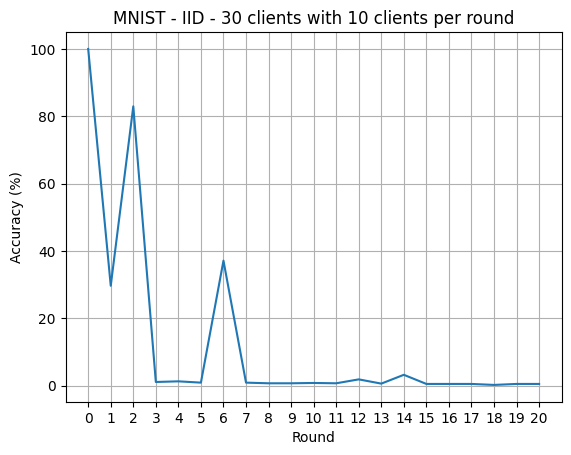

In [80]:
import matplotlib.pyplot as plt

print(f"{history.metrics_centralized = }")
# print(f"{history.metrics_distributed = }")


global_accuracy_centralised = history.metrics_centralized["accuracy"]
# global_accuracy_centralised = history.metrics_distributed["accuracy"]

round = [data[0] for data in global_accuracy_centralised]
acc = [data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title("MNIST - IID - 30 clients with 10 clients per round")
xticks_result = plt.xticks(range(1, 22`))
# plt.yticks(range(0, 100))